In [ ]:
# 1. Imports, Flags, Paths, and Data Loading
import os, json, itertools
from pathlib import Path
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch_geometric
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from torch_geometric.data import DataLoader
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# ---- Control flags ----
DO_PRELOAD = True        # Load saved models BEFORE training (warm start)
DO_TRAIN   = False         # Train models in this run
DO_SAVE    = False         # Save models after (optional) training
DO_EVAL    = True         # Evaluate and plot
DO_SWEEP   = False        # Run a parameter sweep as part of training (replaces default training loops)

# ---- Checkpoint paths (used for preload and save/reload) ----
save_dir = "./saved_models"
os.makedirs(save_dir, exist_ok=True)
attn_ckpt_path = os.path.join(save_dir, "gnn_attention_checkpoint.pth")
gcn_ckpt_path  = os.path.join(save_dir, "gnn_gcn_checkpoint.pth")

# ---- Sweep grids (edit as desired) ----
# GCN sweep grids
SWEEP_GCN_EPOCHS        = (400,)         # use smaller epochs for quick sweeps
SWEEP_GCN_LR            = (5e-4, 1e-3)
SWEEP_GCN_HIDDEN_DIM    = (128, 256)
SWEEP_GCN_NUM_CONVS     = (1, 2)
SWEEP_GCN_MLP_LAYERS    = (2,)
SWEEP_GCN_HIDDEN_NEUR   = (128, 256)
SWEEP_GCN_DROPOUT       = (0.0, 0.1)

# Attention sweep grids
SWEEP_ATTN_EPOCHS       = (400,)
SWEEP_ATTN_LR           = (5e-4, 1e-3)
SWEEP_ATTN_HIDDEN_DIM   = (64, 128)
SWEEP_ATTN_NUM_LAYERS   = (3, 4)
SWEEP_ATTN_NUM_HEADS    = (4,)
SWEEP_ATTN_MLP_LAYERS   = (2,)
SWEEP_ATTN_HIDDEN_NEUR  = (128,)
SWEEP_ATTN_DROPOUT      = (0.1,)

# ---- Fixed subnode geometry for 11 node groups ----
x_subnodes = [
    [1.0],
    [1.0, 1.0, 0.5],
    [1.0, 1.0, 0.0],
    [0.5, 0.5, 1.0],
    [0.5],
    [0.5, 0.5, 0.0],
    [1.0, 0.0, 0.0],
    [0.5, 0.0, 0.0],
    [0.0],
    [1.0, 0.5, 0.0],
    [1.0, 0.5, 0.0],
]
y_subnodes = [
    [1.0],
    [1.0, 0.5, 1.0],
    [1.0, 0.0, 1.0],
    [0.5, 1.0, 0.5],
    [0.5],
    [0.5, 0.0, 0.5],
    [0.0, 1.0, 0.0],
    [0.0, 0.5, 0.0],
    [0.0],
    [0.5, 0.0, 1.0],
    [0.0, 1.0, 0.5],
]
z_subnodes = [
    [1.0],
    [0.5, 1.0, 1.0],
    [0.0, 1.0, 1.0],
    [1.0, 0.5, 0.5],
    [0.5],
    [0.0, 0.5, 0.5],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 0.5],
    [0.0],
    [0.0, 1.0, 0.5],
    [0.5, 0.0, 1.0],
]

# Precompute subnode coordinates and normalized versions
num_node_groups = len(x_subnodes)
subnode_coords, subnode_coords_norm = [], []
for i in range(num_node_groups):
    xs = np.array(x_subnodes[i], dtype=float)
    ys = np.array(y_subnodes[i], dtype=float)
    zs = np.array(z_subnodes[i], dtype=float)
    coords = np.stack([xs, ys, zs], axis=1)  # [k_i, 3]
    subnode_coords.append(coords)
    coords_norm = 2.0 * (coords - 0.5)      # [0,1] -> [-1,1]
    subnode_coords_norm.append(coords_norm)

SQRT3 = np.sqrt(3.0)

# Import data
data = pd.read_pickle('../data/connectivity_compliance_matrices.pkl')
data.rename(columns={'ρ': 'rho'}, inplace=True)
data['mean_E'] = data[['E1', 'E2', 'E3']].mean(axis=1)  # not used as input
data['mean_G'] = data[['G12', 'G23', 'G13']].mean(axis=1)  # not used as input

# Extract relevant columns
X = data[['connectivity_matrix', 'compliance_matrix', 'rho', 'mean_E']]
display(X.head())

,connectivity_matrix,compliance_matrix,rho,mean_E
0,"[[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...","[[16.2442166588418, -4.390589663678543, -4.392...",0.3,0.061528
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[22.194443522542244, -7.184492662134119, -7.1...",0.3,0.045108
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[21.44865815819801, -6.467827160497426, -6.44...",0.3,0.046636
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[15.247634909853652, -3.931170890685161, -3.9...",0.3,0.065567
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[23.16273271145176, -5.511611078765939, -5.66...",0.3,0.043226


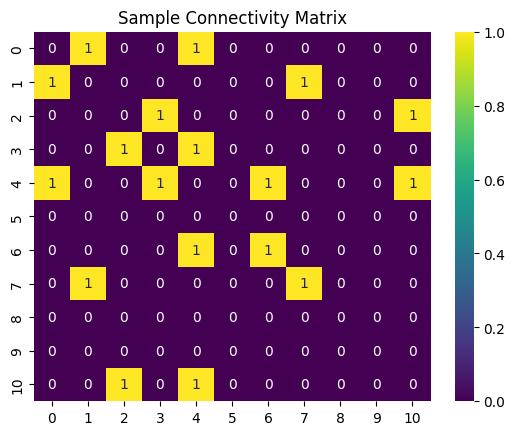

In [6]:
# Plot first row's connectivity matrix
sample_conn = X.iloc[0]['connectivity_matrix']
sns.heatmap(sample_conn, cmap='viridis', annot=True)
plt.title("Sample Connectivity Matrix")
plt.show()

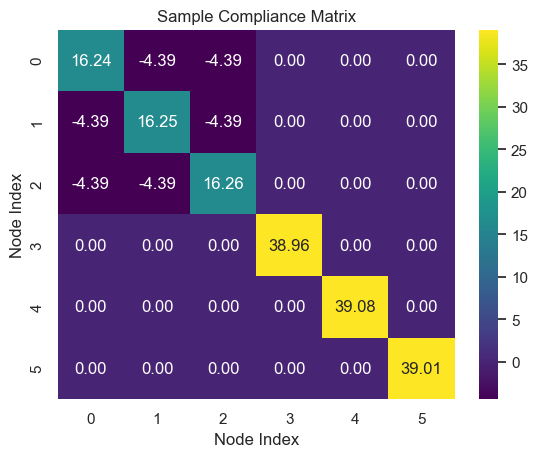

Compliance Matrix max: 39.08, min: -4.39


In [49]:
# Plot compliance matrix
sample_C = X.iloc[0]['compliance_matrix']
sns.heatmap(sample_C, cmap='viridis', annot=True, fmt=".2f")
plt.title('Sample Compliance Matrix')
plt.xlabel('Node Index')
plt.ylabel('Node Index')
plt.show()
print(f"Compliance Matrix max: {sample_C.max():.2f}, min: {sample_C.min():.2f}")

In [20]:
# 2. Graph Construction Utilities

def build_node_features(conn_mat, rho):
    """
    Features per node i: [subnode_count, degree, 3*(x,y,z) of up to 3 subnodes (normalized, padded)]
    """
    num_nodes = conn_mat.shape[0]
    degrees = conn_mat.sum(axis=1)
    feats = []
    for i in range(num_nodes):
        coords_norm = subnode_coords_norm[i]   # [k_i, 3]
        k_i = coords_norm.shape[0]
        if k_i >= 3:
            coords3 = coords_norm[:3]
        else:
            reps = 3 - k_i
            pad = np.repeat(coords_norm[0:1, :], reps, axis=0)
            coords3 = np.vstack([coords_norm, pad])
        coords_flat = coords3.reshape(-1)      # 9 values
        feats.append([float(k_i), float(degrees[i])] + coords_flat.tolist())
    return torch.tensor(feats, dtype=torch.float32)  # [N, 11]

def compute_edge_index_and_attr(conn_mat):
    """
    edge_index from nonzero entries (directed).
    edge_attr: normalized min subnode-subnode distance per edge.
    """
    edges = np.array(np.nonzero(conn_mat)).T
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    dists = []
    for (i, j) in edges:
        ci, cj = subnode_coords[i], subnode_coords[j]
        diff = ci[:, None, :] - cj[None, :, :]
        dmat = np.linalg.norm(diff, axis=2)
        d_norm = float(dmat.min()) / SQRT3
        dists.append([d_norm])
    edge_attr = torch.tensor(dists, dtype=torch.float32)
    return edge_index, edge_attr

def construct_graph_data(row):
    conn_mat = row['connectivity_matrix']
    C_mat = row['compliance_matrix']
    rho = float(row['rho'])

    # per-sample min-max normalize compliance
    cmin, cmax = float(np.min(C_mat)), float(np.max(C_mat))
    C_norm = np.zeros_like(C_mat, dtype=float) if (cmax - cmin) == 0 else (C_mat - cmin) / (cmax - cmin)

    x = build_node_features(conn_mat, rho)
    edge_index, edge_attr = compute_edge_index_and_attr(conn_mat)

    return Data(
        x=x,
        edge_index=edge_index,
        edge_attr=edge_attr,
        y=torch.tensor(C_norm.flatten(), dtype=torch.float32),
        rho=torch.tensor([rho], dtype=torch.float32),
    )


In [21]:
# 3. Build Graph Dataset & Print Stats

graph_data_list = X.apply(construct_graph_data, axis=1).tolist()
print(f"Constructed {len(graph_data_list)} graph data objects.")

train_data, test_data = train_test_split(graph_data_list, test_size=0.2, random_state=42)
print(f"Training set size: {len(train_data)}")
print(f"Testing set size: {len(test_data)}")
print('len(y) per graph =', len(train_data[0].y))
print(train_data[0])

num_node_features = int(train_data[0].x.shape[1])  # features per node
output_dim = int(train_data[0].y.shape[0])        # flattened compliance matrix length
num_nodes = int(np.sqrt(output_dim))
print(f"Node features per node: {num_node_features}")
print(f"Number of nodes per graph (sqrt of output dim): {num_nodes}")
print(f"Output dim (flattened compliance matrix): {output_dim}")

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_data,  batch_size=32, shuffle=False)

Constructed 2624 graph data objects.
Training set size: 2099
Testing set size: 525
len(y) per graph = 36
Data(x=[11, 11], edge_index=[2, 21], edge_attr=[21, 1], y=[36], rho=[1])
Node features per node: 11
Number of nodes per graph (sqrt of output dim): 6
Output dim (flattened compliance matrix): 36


In [22]:
# 4. GNN Model Definitions

import torch
from torch.nn import Linear, Dropout
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
import math
from torch import nn

embedding_size = 64  # not strictly used

class GNN_v1(torch.nn.Module):
    """Graph-level regressor: GCNConv + pooling + MLP, uses edge weights and rho."""
    def __init__(self, in_channels, embedding_size=128, out_dim=36, dropout=0.0,
                 mlp_layers=2, hidden_neurons=128, num_convs=1, conv_channels=None):
        super().__init__()
        torch.manual_seed(42)
        widths = list(map(int, conv_channels)) if conv_channels is not None else [int(embedding_size)] * max(int(num_convs), 1)
        convs, in_c = [], in_channels
        for w in widths:
            convs.append(GCNConv(in_c, w))
            in_c = w
        self.convs = torch.nn.ModuleList(convs)
        self.dropout = Dropout(dropout)
        last_embed = widths[-1]
        d_in = last_embed * 2 + 1  # + rho
        hdim = last_embed if hidden_neurons is None else int(hidden_neurons)
        layers = [Linear(d_in, hdim), torch.nn.ReLU(), Dropout(dropout)]
        for _ in range(mlp_layers - 1):
            layers += [Linear(hdim, hdim), torch.nn.ReLU(), Dropout(dropout)]
        layers += [Linear(hdim, out_dim)]
        self.mlp = torch.nn.Sequential(*layers)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        edge_weight = data.edge_attr.view(-1) if hasattr(data, 'edge_attr') else None
        rho = data.rho.to(x.device)
        h = x
        for conv in self.convs:
            h = conv(h, edge_index, edge_weight=edge_weight)
            h = F.relu(h)
        hg = torch.cat([gmp(h, batch), gap(h, batch)], dim=1)
        if rho.dim() == 1:
            rho = rho.unsqueeze(1)
        hg = torch.cat([hg, rho], dim=1)
        hg = self.dropout(hg)
        return self.mlp(hg)

class MultiHeadGraphAttention(nn.Module):
    """Multi-head self-attention with adjacency mask and distance penalty."""
    def __init__(self, in_dim, out_dim, num_heads=4, dropout=0.1):
        super().__init__()
        assert out_dim % num_heads == 0
        self.num_heads = num_heads
        self.d_k = out_dim // num_heads
        self.W_q = nn.Linear(in_dim, out_dim)
        self.W_k = nn.Linear(in_dim, out_dim)
        self.W_v = nn.Linear(in_dim, out_dim)
        self.out_proj = nn.Linear(out_dim, out_dim)
        self.dropout = nn.Dropout(dropout)
        self.dist_scale = nn.Parameter(torch.tensor(1.0))

    def forward(self, X, A, D=None):
        B, N, _ = X.shape
        Q, K, V = self.W_q(X), self.W_k(X), self.W_v(X)
        h, d_k = self.num_heads, self.d_k
        Q = Q.view(B, N, h, d_k).transpose(1, 2)
        K = K.view(B, N, h, d_k).transpose(1, 2)
        V = V.view(B, N, h, d_k).transpose(1, 2)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
        if D is not None:
            scores = scores - self.dist_scale * D.unsqueeze(1)  # [B,1,N,N]
        scores = scores.masked_fill(A.unsqueeze(1) <= 0, -1e9)
        attn = torch.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        out = torch.matmul(attn, V)
        out = out.transpose(1, 2).contiguous().view(B, N, h * d_k)
        return self.out_proj(out)

class GNN_v2_Attention(nn.Module):
    """Attention-enabled graph regressor using MultiHeadGraphAttention and rho."""
    def __init__(self, in_channels, hidden_dim=64, out_dim=36, num_heads=4,
                 num_layers=3, mlp_layers=2, hidden_neurons=128, dropout=0.1):
        super().__init__()
        torch.manual_seed(42)
        layers, dim = [], in_channels
        for _ in range(int(num_layers)):
            layers.append(MultiHeadGraphAttention(dim, hidden_dim, num_heads=num_heads, dropout=dropout))
            dim = hidden_dim
        self.att_layers = nn.ModuleList(layers)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        d_in = hidden_dim + 1  # + rho
        hdim = hidden_dim if hidden_neurons is None else int(hidden_neurons)
        mlp = [nn.Linear(d_in, hdim), nn.ReLU(), nn.Dropout(dropout)]
        for _ in range(int(mlp_layers) - 1):
            mlp += [nn.Linear(hdim, hdim), nn.ReLU(), nn.Dropout(dropout)]
        mlp += [nn.Linear(hdim, out_dim)]
        self.mlp = nn.Sequential(*mlp)

    def _dense_mats(self, x, edge_index, batch, edge_attr):
        device = x.device
        num_graphs = int(batch.max().item()) + 1
        src, dst = edge_index
        eattr = edge_attr.view(-1).to(device)
        A_list, D_list, X_list = [], [], []
        for g in range(num_graphs):
            mask = (batch == g)
            idx = mask.nonzero(as_tuple=False).view(-1)
            Xg = x[idx]; Ng = Xg.size(0)
            map_idx = -torch.ones(x.size(0), dtype=torch.long, device=device)
            map_idx[idx] = torch.arange(Ng, device=device)
            e_mask = mask[src] & mask[dst]
            s_loc, d_loc = map_idx[src[e_mask]], map_idx[dst[e_mask]]
            e_g = eattr[e_mask]
            A = torch.zeros(Ng, Ng, device=device)
            D = torch.zeros(Ng, Ng, device=device)
            A[s_loc, d_loc] = 1.0; D[s_loc, d_loc] = e_g
            A[d_loc, s_loc] = 1.0; D[d_loc, s_loc] = e_g
            A.fill_diagonal_(1.0)
            A_list.append(A); D_list.append(D); X_list.append(Xg)
        return A_list, D_list, X_list

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        edge_attr, rho = data.edge_attr, data.rho.to(x.device)
        A_list, D_list, X_list = self._dense_mats(x, edge_index, batch, edge_attr)
        g_embs = []
        for A, D, Xg in zip(A_list, D_list, X_list):
            h = Xg.unsqueeze(0); A_ = A.unsqueeze(0); D_ = D.unsqueeze(0)
            for att in self.att_layers:
                h = att(h, A_, D_); h = self.activation(h); h = self.dropout(h)
            g_embs.append(h.mean(dim=1))  # [1, hidden_dim]
        g_emb = torch.cat(g_embs, dim=0)
        if rho.dim() == 1:
            rho = rho.unsqueeze(1)
        g_emb = torch.cat([g_emb, rho], dim=1)
        return self.mlp(g_emb)


In [23]:
# 5. Instantiate Models, Optional Preload, Training Setup and Loops

def train_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    total_squared_error, total_elements = 0.0, 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        pred = model(batch)
        target = batch.y.view_as(pred).to(device)
        loss = loss_fn(pred, target)
        loss.backward()
        optimizer.step()
        total_squared_error += F.mse_loss(pred, target, reduction='sum').item()
        total_elements += pred.numel()
    return total_squared_error / total_elements if total_elements > 0 else float('nan')

@torch.no_grad()
def mse_over_loader(model, loader, device):
    model.eval()
    total_se, total_n = 0.0, 0
    for batch in loader:
        batch = batch.to(device)
        pred = model(batch)
        tgt  = batch.y.view_as(pred)
        total_se += F.mse_loss(pred, tgt, reduction='sum').item()
        total_n  += pred.numel()
    return total_se / total_n if total_n > 0 else float('nan')

# Build default models (used when not sweeping)
model_attn = GNN_v2_Attention(
    in_channels=num_node_features,
    hidden_dim=64,
    out_dim=output_dim,
    num_heads=4,
    num_layers=3,
    mlp_layers=2,
    hidden_neurons=128,
    dropout=0.1,
).to(device)

model_gcn = GNN_v1(
    in_channels=num_node_features,
    embedding_size=128,
    out_dim=output_dim,
    dropout=0.0,
    mlp_layers=2,
    hidden_neurons=128,
    num_convs=1
).to(device)

# ---- Optional: preload saved weights BEFORE training (warm start) ----
if DO_PRELOAD:
    if os.path.isfile(attn_ckpt_path):
        ckpt = torch.load(attn_ckpt_path, map_location=device)
        model_attn.load_state_dict(ckpt["model_state_dict"])
        print(f"Preloaded Attention weights from {attn_ckpt_path}")  # state_dict best-practice [web:257]
    else:
        print(f"Attention preload path not found: {attn_ckpt_path}")
    if os.path.isfile(gcn_ckpt_path):
        ckpt = torch.load(gcn_ckpt_path, map_location=device)
        model_gcn.load_state_dict(ckpt["model_state_dict"])
        print(f"Preloaded GCN weights from {gcn_ckpt_path}")
    else:
        print(f"GCN preload path not found: {gcn_ckpt_path}")

loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer_attn = torch.optim.Adam(model_attn.parameters(), lr=0.0005)
optimizer_gcn  = torch.optim.Adam(model_gcn.parameters(),  lr=0.0005)

if DO_TRAIN and DO_SWEEP:
    # ---------- Parameter Sweep ----------
    sweep_rows = []

    # GCN sweep
    for ep, lr, hd, nconv, mlp, hn, do in itertools.product(
        SWEEP_GCN_EPOCHS, SWEEP_GCN_LR, SWEEP_GCN_HIDDEN_DIM,
        SWEEP_GCN_NUM_CONVS, SWEEP_GCN_MLP_LAYERS, SWEEP_GCN_HIDDEN_NEUR,
        SWEEP_GCN_DROPOUT
    ):
        cfg = dict(model="gcn", epochs=ep, lr=lr, hidden_dim=hd, num_convs=nconv,
                   mlp_layers=mlp, hidden_neurons=hn, dropout=do)
        # Build per-config model
        conv_channels = [int(hd)] * int(nconv)
        m = GNN_v1(
            in_channels=num_node_features,
            embedding_size=int(hd),
            out_dim=output_dim,
            dropout=float(do),
            mlp_layers=int(mlp),
            hidden_neurons=int(hn),
            num_convs=int(nconv),
            conv_channels=conv_channels
        ).to(device)
        opt = torch.optim.Adam(m.parameters(), lr=float(lr))
        # Train
        for e in range(int(ep)):
            _ = train_epoch(m, train_loader, opt, loss_fn, device)
        # Evaluate quick MSE on test
        test_mse = mse_over_loader(m, test_loader, device)
        sweep_rows.append({**cfg, "test_mse": float(test_mse)})

    # Attention sweep
    for ep, lr, hd, nl, nh, mlp, hn, do in itertools.product(
        SWEEP_ATTN_EPOCHS, SWEEP_ATTN_LR, SWEEP_ATTN_HIDDEN_DIM,
        SWEEP_ATTN_NUM_LAYERS, SWEEP_ATTN_NUM_HEADS, SWEEP_ATTN_MLP_LAYERS,
        SWEEP_ATTN_HIDDEN_NEUR, SWEEP_ATTN_DROPOUT
    ):
        cfg = dict(model="attn", epochs=ep, lr=lr, hidden_dim=hd, num_layers=nl,
                   num_heads=nh, mlp_layers=mlp, hidden_neurons=hn, dropout=do)
        # Build per-config model
        m = GNN_v2_Attention(
            in_channels=num_node_features,
            hidden_dim=int(hd),
            out_dim=output_dim,
            num_heads=int(nh),
            num_layers=int(nl),
            mlp_layers=int(mlp),
            hidden_neurons=int(hn),
            dropout=float(do),
        ).to(device)
        opt = torch.optim.Adam(m.parameters(), lr=float(lr))
        # Train
        for e in range(int(ep)):
            _ = train_epoch(m, train_loader, opt, loss_fn, device)
        # Evaluate quick MSE on test
        test_mse = mse_over_loader(m, test_loader, device)
        sweep_rows.append({**cfg, "test_mse": float(test_mse)})

    sweep_df = pd.DataFrame(sweep_rows).sort_values(by="test_mse", ascending=True).reset_index(drop=True)
    print("Sweep results (best first):")
    display(sweep_df.head(10))

elif DO_TRAIN and not DO_SWEEP:
    # ---------- Default training (your previous loops) ----------
    print("Starting training (Attention)...")
    attn_losses, EPOCHS = [], 2500
    for epoch in range(EPOCHS):
        train_loss = train_epoch(model_attn, train_loader, optimizer_attn, loss_fn, device)
        attn_losses.append(train_loss)
        if epoch % 5 == 0:
            print(f"[ATTN] Epoch {epoch} | Train MSE {train_loss:.6f}")
    sns.set(style="whitegrid")
    ax = sns.lineplot(x=list(range(len(attn_losses))), y=attn_losses)
    ax.set(xlabel="Epoch", ylabel="Mean Squared Error (MSE)")
    plt.title("Attention Model Training Loss"); plt.show()

    print("Starting training (GCN)...")
    gcn_losses, EPOCHS = [], 2500
    for epoch in range(EPOCHS):
        train_loss = train_epoch(model_gcn, train_loader, optimizer_gcn, loss_fn, device)
        gcn_losses.append(train_loss)
        if epoch % 5 == 0:
            print(f"[GCN] Epoch {epoch} | Train MSE {train_loss:.6f}")
    sns.set(style="whitegrid")
    ax = sns.lineplot(x=list(range(len(gcn_losses))), y=gcn_losses)
    ax.set(xlabel="Epoch", ylabel="Mean Squared Error (MSE)")
    plt.title("GCN Model Training Loss"); plt.show()


Preloaded Attention weights from ./saved_models/gnn_attention_checkpoint.pth
Preloaded GCN weights from ./saved_models/gnn_gcn_checkpoint.pth


Attention metrics: {'MAE': 0.00823308527469635, 'MSE': 0.00024697312619537115, 'RMSE': 0.015715378652624668, 'R2': 0.996857659791567}
GCN metrics: {'MAE': 0.007370175328105688, 'MSE': 0.00027414553915150464, 'RMSE': 0.016557340944472473, 'R2': 0.9965119333812664}


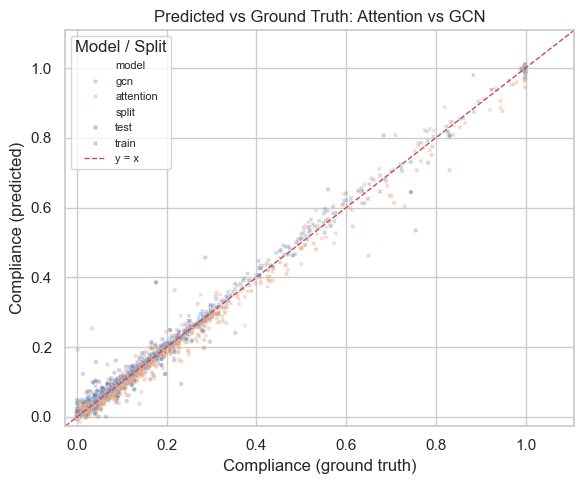

In [24]:
# 6. Evaluation and Metrics

def evaluate_model(loader_dict, model, device, model_name):
    model.eval()
    ys, preds, splits = [], [], []
    with torch.no_grad():
        for split_name, split_loader in loader_dict.items():
            for batch in split_loader:
                batch = batch.to(device)
                pred = model(batch)
                target = batch.y.view_as(pred)
                ys.append(target.detach().cpu().numpy().ravel())
                preds.append(pred.detach().cpu().numpy().ravel())
                splits.append(np.full_like(ys[-1], fill_value=split_name, dtype=object))
    y_true = np.concatenate(ys, axis=0)
    y_pred = np.concatenate(preds, axis=0)
    split_arr = np.concatenate(splits, axis=0)
    return pd.DataFrame({"y_true": y_true, "y_pred": y_pred, "split": split_arr, "model": model_name})

def regression_metrics(y_true, y_pred):
    # MAE, MSE, RMSE, R² (standard definitions). [web:302][web:304]
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    mae = float(np.mean(np.abs(y_pred - y_true)))
    mse = float(np.mean((y_pred - y_true) ** 2))
    rmse = float(np.sqrt(mse))
    sst = float(np.sum((y_true - y_true.mean())**2))
    sse = float(np.sum((y_true - y_pred)**2))
    r2 = float(1.0 - sse / sst) if sst > 0 else float('nan')
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

if DO_EVAL:
    loader_dict = {"train": train_loader, "test": test_loader}
    attn_df = evaluate_model(loader_dict, model_attn, device, "attention")
    gcn_df  = evaluate_model(loader_dict, model_gcn,  device, "gcn")

    print("Attention metrics:", regression_metrics(attn_df["y_true"].values, attn_df["y_pred"].values))
    print("GCN metrics:",      regression_metrics(gcn_df["y_true"].values,  gcn_df["y_pred"].values))

    all_df = pd.concat([attn_df, gcn_df], ignore_index=True)
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.scatterplot(
        data=all_df.sample(min(len(all_df), 5000), random_state=0),
        x="y_true", y="y_pred", hue="model", style="split",
        alpha=0.3, s=10, ax=ax
    )
    xy_min = float(min(all_df["y_true"].min(), all_df["y_pred"].min()))
    xy_max = float(max(all_df["y_true"].max(), all_df["y_pred"].max()))
    ax.axline((0, 0), slope=1.0, color="r", linestyle="--", linewidth=1.0, label="y = x")
    ax.set_xlim(xy_min, xy_max); ax.set_ylim(xy_min, xy_max)
    ax.set_xlabel("Compliance (ground truth)"); ax.set_ylabel("Compliance (predicted)")
    ax.legend(title="Model / Split", fontsize=8); ax.set_title("Predicted vs Ground Truth: Attention vs GCN")
    plt.tight_layout(); plt.show()


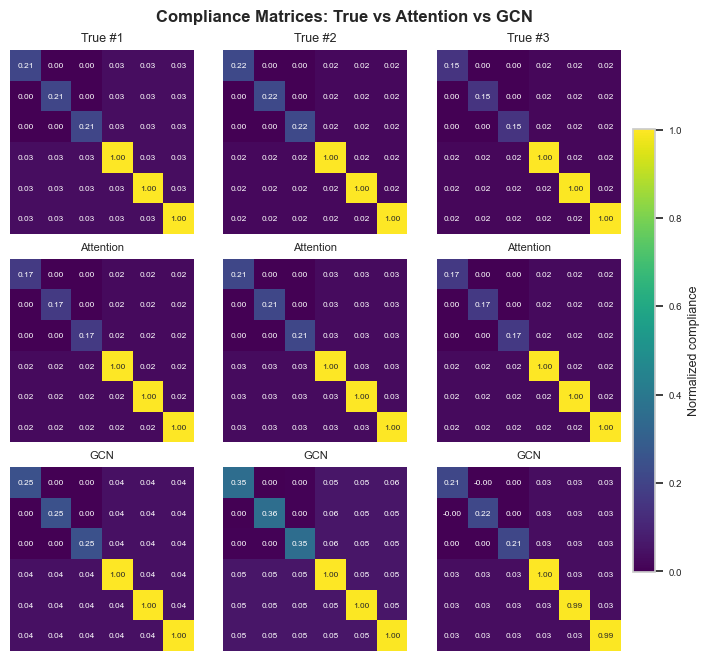

In [25]:
# 7. Visualize Predicted vs True Compliance Matrices

from torch_geometric.data import Batch

def visualize_compliance_matrices_dual(
    model_attn, model_gcn, dataset, device, num_examples=3, fmt=".2f"
):
    model_attn.eval(); model_gcn.eval()
    if len(dataset) == 0:
        print("Dataset is empty; nothing to visualize."); return
    n = min(num_examples, len(dataset))
    idxs = np.random.choice(len(dataset), size=n, replace=False)
    samples = [dataset[i] for i in idxs]
    batch = Batch.from_data_list(samples).to(device)
    with torch.no_grad():
        pred_attn = model_attn(batch).cpu().numpy()
        pred_gcn  = model_gcn(batch).cpu().numpy()
    true_mats, attn_mats, gcn_mats = [], [], []
    for i, d in enumerate(samples):
        true_mats.append(d.y.view(num_nodes, num_nodes).cpu().numpy())
        attn_mats.append(pred_attn[i].reshape(num_nodes, num_nodes))
        gcn_mats.append(pred_gcn[i].reshape(num_nodes, num_nodes))
    all_vals = np.concatenate([m.ravel() for m in (true_mats + attn_mats + gcn_mats)])
    vmin, vmax = all_vals.min(), all_vals.max()
    fig, axes = plt.subplots(3, n, figsize=(2.4 * n, 6.5), constrained_layout=True)
    if n == 1: axes = np.array(axes).reshape(3, 1)
    im_for_cbar = None; annot_kws = {"fontsize": 6}
    for i, (t, a, g) in enumerate(zip(true_mats, attn_mats, gcn_mats)):
        ax_t, ax_a, ax_g = axes[0, i], axes[1, i], axes[2, i]
        im_t = sns.heatmap(t, ax=ax_t, cmap="viridis", vmin=vmin, vmax=vmax, annot=True, fmt=fmt, annot_kws=annot_kws, square=True, cbar=False)
        ax_t.set_title(f"True #{i+1}", fontsize=9); ax_t.set_xticks([]); ax_t.set_yticks([])
        im_a = sns.heatmap(a, ax=ax_a, cmap="viridis", vmin=vmin, vmax=vmax, annot=True, fmt=fmt, annot_kws=annot_kws, square=True, cbar=False)
        ax_a.set_title("Attention", fontsize=8); ax_a.set_xticks([]); ax_a.set_yticks([])
        im_g = sns.heatmap(g, ax=ax_g, cmap="viridis", vmin=vmin, vmax=vmax, annot=True, fmt=fmt, annot_kws=annot_kws, square=True, cbar=False)
        ax_g.set_title("GCN", fontsize=8); ax_g.set_xticks([]); ax_g.set_yticks([])
        if im_for_cbar is None: im_for_cbar = im_t.collections[0]
    cbar = fig.colorbar(im_for_cbar, ax=axes.ravel().tolist(), fraction=0.035, pad=0.02)
    cbar.set_label("Normalized compliance", fontsize=9); cbar.ax.tick_params(labelsize=7)
    fig.suptitle("Compliance Matrices: True vs Attention vs GCN", fontsize=12, weight="bold")
    plt.show()

if DO_EVAL:
    visualize_compliance_matrices_dual(
        model_attn=model_attn,
        model_gcn=model_gcn,
        dataset=test_data,
        device=device,
        num_examples=3,
        fmt=".2f"
    )


In [26]:
# 8. Optional Save (integrated)

if DO_SAVE:
    torch.save(
        {
            "model_state_dict": model_attn.state_dict(),
            "optimizer_state_dict": optimizer_attn.state_dict(),
            "num_node_features": num_node_features,
            "output_dim": output_dim,
        },
        attn_ckpt_path,
    )
    print(f"Saved attention model checkpoint to {attn_ckpt_path}")  # state_dict pattern [web:257]

    torch.save(
        {
            "model_state_dict": model_gcn.state_dict(),
            "optimizer_state_dict": optimizer_gcn.state_dict(),
            "num_node_features": num_node_features,
            "output_dim": output_dim,
        },
        gcn_ckpt_path,
    )
    print(f"Saved GCN model checkpoint to {gcn_ckpt_path}")
